# Optimization for Machine Learning: Computer Lab 1

## 2. Preprocessing the data

Here, we load the data, standardize it, and set it in the appropriate shape for performing linear regression. You do not need to complete anything in this section; however it is important that you understand what the code is doing. See the pdf instructions for more details.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading data
data_matrix_train, COP_train, data_matrix_test, COP_test, names = np.load('data_center_data_matrix.npy', allow_pickle=True)

In [3]:
# centering and normalizing the matrix
matrix_mean = np.mean(data_matrix_train, axis=0)
M = data_matrix_train - matrix_mean

matrix_std = np.std(M, axis=0)
M = M / matrix_std

In [4]:
M.shape

(722, 892)

In [5]:
# Building the corresponding matrices A,b for linear regression
A = np.hstack([M, np.ones((M.shape[0],1)), -(M.T * COP_train[:,3]).T])
b = COP_train[:,3]

# Building the same matrices for the test set
M_test = (data_matrix_test - matrix_mean) / matrix_std
A_test = np.hstack([M_test, np.ones((M_test.shape[0],1)), -(M_test.T * COP_test[:,3]).T])
b_test = COP_test[:,3]

d = A.shape[1]

## 3. Ordinary least squares

We now wish to solve the problem
$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2
$$

### Question 3.1

We know that $(Aw)_t = \tilde{x}(t)^\top w_1 + w_0 - y(t) \times \tilde{x}(t)^\top w_2$ and $b_t = y(t)$, where $\tilde{x}(t), w_1, w_2 \in \mathbb{R}^n$ and $w_0, y(t) \in \mathbb{R}$. We assume that $Aw = b$. Then,
\begin{align*}
Aw &= b \\
\implies (Aw)_t &= b_t \\
\implies \tilde{x}(t)^\top w_1 + w_0 - y(t) \times \tilde{x}(t)^\top w_2 &= y(t) \\
\implies \langle \tilde{x}(t), w_1 \rangle + w_0 - y(t) \langle \tilde{x}(t), w_2 \rangle &= y(t) \\
\implies (1 + \langle \tilde{x}(t), w_2 \rangle) y(t) &= \langle \tilde{x}(t), w_1 \rangle + w_0 \\
\implies y(t) &= \frac{\langle \tilde{x}(t), w_1 \rangle + w_0}{1 + \langle \tilde{x}(t), w_2 \rangle} \\
&= \frac{\langle w_1, \tilde{x}(t) \rangle + w_0}{\langle w_2, \tilde{x}(t) \rangle + 1} \\
&= \frac{w_1^\top \tilde{x}(t) + w_0}{w_2^\top \tilde{x}(t) + 1}
\end{align*}

In [6]:
## Question 3.2: solve with the numpy least squares solver

# COMPLETE HERE
w_least_squares, residuals, rank, s = np.linalg.lstsq(A, b)

In [7]:
## Question 3.3

# COMPLETE HERE
N_test = A_test.shape[0]
test_error = np.sum((A_test @ w_least_squares - b_test) ** 2) / N_test
print(f"Test error for least squares solution : {test_error}")

Test error for least squares solution : 780.8984793523532


### Adding $\ell_2$ regularization

In order to improve the performance on the test set, we add $\ell_2$ regularization:

$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2 + \frac \lambda 2 \|w\|_2^2
$$

### Question 3.4

Let us compute the $\nabla f_1 (w)$ where $f_1 \colon w \mapsto \frac{1}{2} \| Aw - b \|^2 + \frac{\lambda}{2} \| w \|^2$.
\begin{align*}
f_1 (w + h) &= \frac{1}{2} \| A(w + h) - b \|^2 + \frac{\lambda}{2} \| w + h \|^2 \\
&= \frac{1}{2} (Aw - b + Ah)^\top (Aw - b + Ah) + \frac{\lambda}{2} (w + h)^\top (w + h) \\
&= \frac{1}{2} (Aw - b)^\top (Aw - b) + \frac{1}{2} (Ah)^\top (Aw - b) + \frac{1}{2} (Aw - b)^\top Ah + \frac{1}{2} (Ah)^\top Ah + \frac{\lambda}{2} w^\top w + \frac{\lambda}{2} w^\top h + \frac{\lambda}{2} h^\top w + \frac{\lambda}{2} h^\top h \\
&= f_1(w) + h^\top A^\top (Aw - b) + \frac{1}{2} h^\top A^\top A h + \lambda h^\top w + \frac{\lambda}{2} h^\top h \\
&= f_1(w) + \langle h, \underbrace{A^\top (Aw - b) + \lambda w}_{\nabla f_1(w)} \rangle + \frac{1}{2} \langle h, (\underbrace{A^\top A + \lambda I_n}_{\nabla^2 f_1(w)})h \rangle
\end{align*}

We can easily see that the Hessian $H = A^\top A + \lambda I_n$ is positive semi-definite, so $f_1$ is convex.

In [8]:
lambda_l2 = 1e4

In [9]:
# Question 3.5
def f_l2(w, lambda_l2=1e4):
    return np.sum((A @ w - b) ** 2) / 2 + lambda_l2 * np.sum(w ** 2) / 2

def grad_f_l2(w, lambda_l2=1e4):
    return A.T @ (A @ w - b) + lambda_l2 * w

def gradient_descent(f, grad_f, w0, lambda_l2, gamma, max_iter):
    w = w0.copy()
    
    f_values = []
    gradient_norms = []
    threshold_grad = None

    for t in range(max_iter):
        # COMPLETE HERE
        grad = grad_f(w, lambda_l2)
        w -= gamma * grad
        
        f_values.append(f(w, lambda_l2))
        gradient_norms.append(np.linalg.norm(grad))

        if gradient_norms[-1] < 1:
            break
        
    return w, f_values, gradient_norms

For finding the appropriate step size range, we need to estimate the Lipschitz constant of the gradient.

In [10]:
# COMPLETE HERE
L_l2 = s[0] ** 2 + lambda_l2

In [11]:
# COMPLETE HERE
w0 = np.zeros_like(w_least_squares)
step_size = 1 / L_l2
max_iter = 12_000

w_GD, f_values_GD, gradient_norms_GD = gradient_descent(f_l2, grad_f_l2, w0, lambda_l2, step_size, max_iter)

We now compute the evolution of function values and gradient norm. 

2341


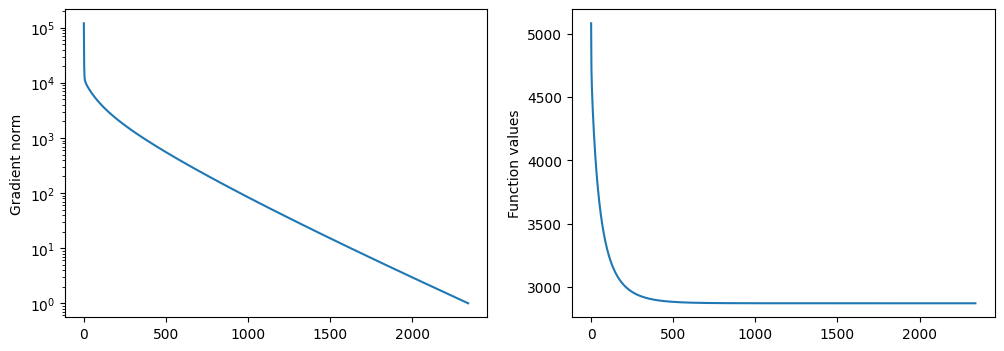

In [12]:
# let us plot the result 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(gradient_norms_GD)
axes[0].semilogy()
axes[0].set_ylabel("Gradient norm")

axes[1].plot(f_values_GD)
axes[1].set_ylabel("Function values")

print(np.where(np.array(gradient_norms_GD) <= 1)[0][0] + 1)

Using the step size $\gamma = \frac{1}{L}$, about 3519 iterations are needed to make $\| \nabla f_1 (w_k) \| \leq 1$.

In [13]:
# Question 3.6 

test_error_l2 = np.sum((A_test @ w_GD - b_test) ** 2) / N_test # COMPLETE HERE
print("Test error for l2 penalized solution : ", test_error_l2)

Test error for l2 penalized solution :  61.522720982022285


What do you observe ?

**Answer**: We can see that the test error for the gradient descent with regularization is substantially smaller. The previous algorithm was probably overfitting and, thus, the test error was very high.

For a faster algorithm, we could implement accelerated gradient descent.

In [14]:
# Question 3.7 (optional) 

def accelerated_gradient_descent(f, grad_f, w0, lambda_l2, gamma, max_iter):
    w = w0.copy()
    
    f_values = []
    gradient_norms = []
    threshold_grad = None
    y_1 = w - gamma * grad_f(w)

    for t in range(max_iter):
        grad = grad_f(w, lambda_l2)
        y = w - gamma * grad
            
        beta = (t + 1) / (t + 4)
        w = y + beta * (y - y_1)

        y_1 = y
        
        f_values.append(f(w, lambda_l2))
        gradient_norms.append(np.linalg.norm(grad))

        if gradient_norms[-1] < 1:
            break
            
    return w, f_values, gradient_norms

In [15]:
# COMPLETE HERE
step_size = 1 / L_l2
max_iter = 12_000

w_AGD, f_values_AGD, gradient_norms_AGD = accelerated_gradient_descent(f_l2, grad_f_l2, w0, lambda_l2, step_size, max_iter)

∇f ≤ 1 at iteration 1081


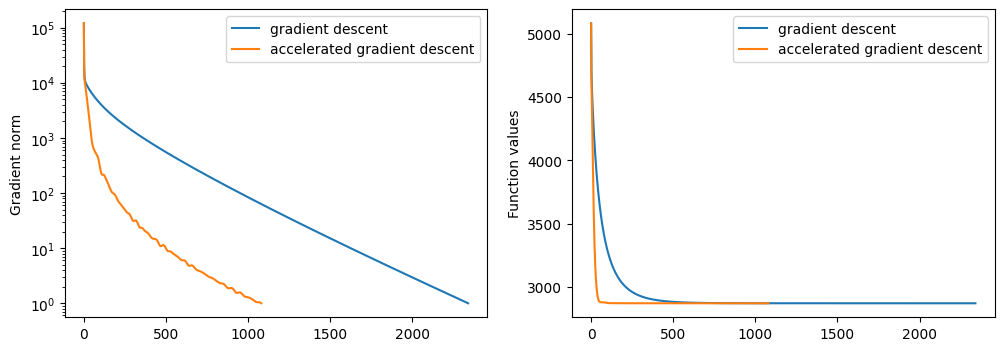

In [16]:
# let us plot the result 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(gradient_norms_GD, label = "gradient descent")
axes[0].plot(gradient_norms_AGD, label = "accelerated gradient descent")
axes[0].semilogy()
axes[0].set_ylabel("Gradient norm")
axes[0].legend()

axes[1].plot(f_values_GD, label = "gradient descent")
axes[1].plot(f_values_AGD, label = "accelerated gradient descent")
axes[1].set_ylabel("Function values")
axes[1].legend()

print(f"∇f ≤ 1 at iteration {np.where(np.array(gradient_norms_AGD) <= 1)[0][0] + 1}")

What do you observe regarding the convergence speed ?

**Answer**:
The convergence speed of the accelerated method is greately superior. However, the function values and the gradient norm are not monotone.

## 4. Adding $\ell_1$ regularization (Lasso)

We now solve 

$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2 + \lambda \|w\|_1
$$

In [17]:
lambda_l1 = 1e3
L_l1 = s[0] ** 2

def S(x, mu):
    return np.where(np.abs(x) > mu, x - np.sign(x) * mu, 0)

def f_l1(w, lambda_l1=1e3):
    return np.sum((A @ w - b) ** 2) / 2 + lambda_l1 * np.sum(np.abs(w))

def grad_f_l1(w):
    return A.T @ (A @ w - b)

## Question 4.2
def prox_l1(x, mu):
    """compute the proximal operator of lambda_l1 * |x|_1
    """
    return S(x, mu)

def proximal_gradient_descent(f, grad_f, w0, lambda_l1, gamma, max_iter, threshold=1):
    w = w0.copy()

    f_values = []
    gradient_norms = []

    for t in range(max_iter):
        w = prox_l1(w - gamma * grad_f(w), lambda_l1 * gamma)
        
        f_values.append(f(w))
        gradient_norms.append(np.linalg.norm(grad_f(w) + lambda_l1 * np.sign(w)))
        
    return w, f_values, gradient_norms

In [18]:
# COMPLETE HERE
step_size = 1 / L_l1
max_iter = 3000

w_PGD, f_values_PGD, gradient_norms_PGD = proximal_gradient_descent(f_l1, grad_f_l1, w0, lambda_l1, step_size, max_iter)

In [19]:
# Question 4.3

test_error_l1 = np.sum((A_test @ w_PGD - b_test) ** 2) / N_test # COMPLETE HERE
print("Test error for l1 penalized solution : ", test_error_l1)

Test error for l1 penalized solution :  3.864220308694197


Compare with the previous test errors. What do you observe?

The test error is now even smaller. Using the Lasso regularization helped the model generalize better and avoid overfitting.

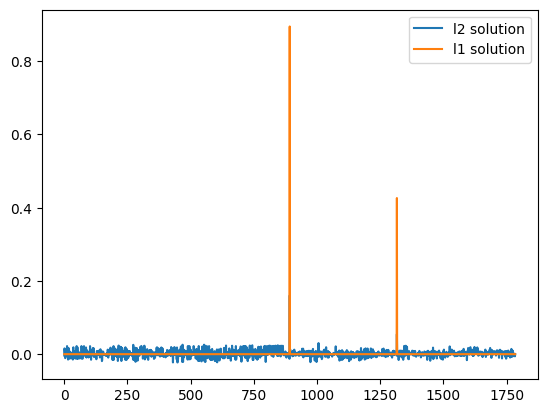

In [20]:
# Let us examine the solution
plt.plot(w_GD, label = "l2 solution")
plt.plot(w_PGD, label = "l1 solution")
plt.legend()

In [21]:
# Question 4.4
def proximal_gradient_descent_linesearch(f, grad_f, w0, lambda_l1, gamma, max_iter, threshold=1):
    w = w0.copy()

    f_values = []
    gradient_norms = []

    for t in range(max_iter):
        gamma_k = gamma
        
        w_k = prox_l1(w - gamma_k * grad_f(w), lambda_l1 * gamma_k)
        
        while f(w_k) > f(w) + np.dot(grad_f(w), w_k - w) + np.sum((w_k - w) ** 2) / (2 * gamma_k):
            gamma_k /= 2
            w_k = prox_l1(w - gamma_k * grad_f(w), lambda_l1 * gamma_k)

        w = w_k
        gamma = 2 * gamma_k
        
        f_values.append(f(w))
        gradient_norms.append(np.linalg.norm(grad_f(w) + lambda_l1 * np.sign(w)))

        if gradient_norms[-1] < threshold:
            break
        
    return w, f_values, gradient_norms

In [22]:
# COMPLETE HERE
step_size = 1 / L_l1
max_iter = 3000

w_PLS, f_values_PLS, gradient_norms_PLS = proximal_gradient_descent_linesearch(f_l1, grad_f_l1, w0, lambda_l1, step_size, max_iter)

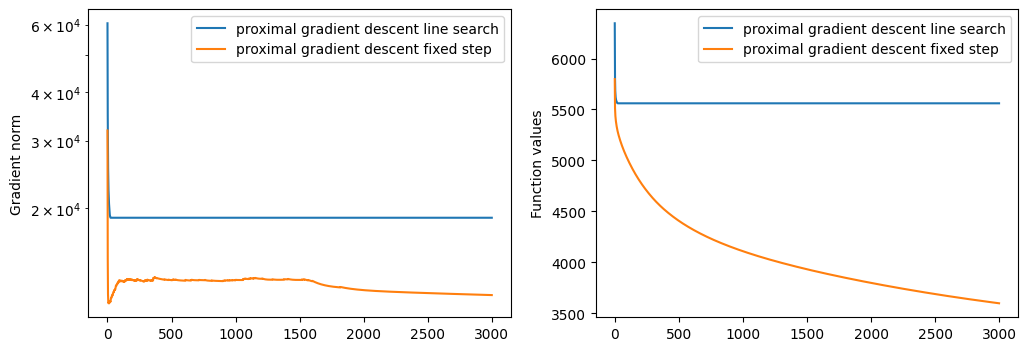

In [23]:
# let us plot the result 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(gradient_norms_PLS, label = "proximal gradient descent line search")
axes[0].plot(gradient_norms_PGD, label = "proximal gradient descent fixed step")
axes[0].semilogy()
axes[0].set_ylabel("Gradient norm")
axes[0].legend()

axes[1].plot(f_values_PLS, label = "proximal gradient descent line search")
axes[1].plot(f_values_PGD, label = "proximal gradient descent fixed step")
axes[1].set_ylabel("Function values")
axes[1].legend()

In [24]:
test_error_ls = np.sum((A_test @ w_PLS - b_test) ** 2) / N_test # COMPLETE HERE
print("Test error for line search with l1 regularization : ", test_error_ls)

Test error for line search with l1 regularization :  23.57652567891521


**Answer**: the convergence speed seems to be higher with the line search algorithm. But, the test error of the fixed step size is still better. This difference in convergence speed may be the result of a higher step size in some iterations.

## Tuning the penalization parameter

How to find the best solution among all those that were comptued? How to choose the penalization parameter $\lambda$?

In [25]:
# Your method here...
def find_lambda(f, grad_f, step_size, proximal, lambda0, a, K):
    w0 = np.zeros_like(w_least_squares)
    max_iter = 3_000

    lambda_ = lambda0

    step_func = gradient_descent
    if proximal:
        step_func = proximal_gradient_descent

    w, _, _ = step_func(f, grad_f, w0, lambda_, step_size, max_iter)
        
    mse = np.sum((A_test @ w - b_test) ** 2) / N_test

    best_lambda = lambda0
    best_mse = mse
    best_w = w

    lambdas = [lambda_]
    mses = [best_mse]
    
    for i in range(K):
        lambda_ *= a

        w, _, _ = step_func(f, grad_f, w0, lambda_, step_size, max_iter)         
        mse = np.sum((A_test @ w - b_test) ** 2) / N_test

        lambdas.append(lambda_)
        mses.append(mse)        

        if mse <= best_mse: # We prioritize smaller lambdas
            best_lambda = lambda_
            best_mse = mse
            best_w = w

    return best_w, best_lambda, best_mse, lambdas, mses

In [26]:
w_l1, lambda_l1, mse_l1, lambdas_l1, mses_l1 = find_lambda(f_l1, grad_f_l1, 1 / L_l1, True, 1e6, 0.9, 120)
w_l2, lambda_l2, mse_l2, lambdas_l2, mses_l2 = find_lambda(f_l2, grad_f_l2, 1 / L_l2, False, 1e6, 0.9, 120)

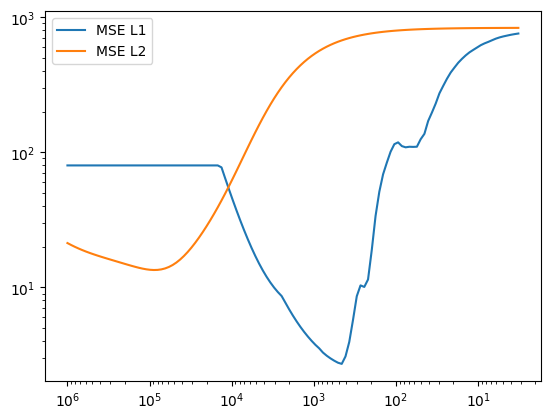

In [27]:
plt.plot(lambdas_l1, mses_l1, label = "MSE L1")
plt.plot(lambdas_l2, mses_l2, label = "MSE L2")
plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [28]:
print(lambda_l1, mse_l1)
print(lambda_l2, mse_l2)

456.7759074507747 2.7162979861278886
88629.38119652505 13.440687581717071


### Question 6.1

**Answer**: We can clearly see that the L1 regularization has better performance in the test set. The optimal parameter found was $\lambda = 457$, which yields a MSE of $2.72$.